# **Introduction** <a name="introduction"></a>

Thirty years ago, the potentially disruptive impact of global warming became front-page news world-wide[[2](https://www.nationalgeographic.com/magazine/2018/07/embark-essay-climate-change-pollution-revkin/)]. This new reality affected the way in which people think about many large companies that contributes a lot to this phenomenon. In that reality, many large companies decided to take initiatives that would reduce their effect in global warming as well as improve their public image. These companies include Levi Strauss & Co, Siemens, Starbucks, and many other companies[[3](https://impacthub.net/5-big-companies-reducing-their-carbon-footprints/)]. This made companies become interested in how people perceive climate change and whether or not they believe it is a real threat.

In this project, we are building a classification machine learning model that classifies people's tweets about climate change into four different categories explained as follow:

![image from actual competition page](https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F2205222%2F8e4d65f2029797e0462b52022451829c%2Fdata.PNG?generation=1590752860255531&alt=media)

We aim to provide an accurate and robust model that gives companies access to a broad base of consumer sentiment, spanning multiple demographic and geographic categories - thus increasing their insights and informing future marketing strategies.




# **Problem Statement** <a name="Problem_statement"></a>


Build a Machine Learning Model that is able to classify whether or not a person believes in climate change, based on their novel tweet data.

We are going to use the Nltk package to apply various NLP techniques, such as tokenization, POS tagging and lemmatization to build meaningful features from a raw Twitter dataset. With these features, we are going to experiment different learning algorithms to build a sentiment analysis model.

# Table of contents

1. [Introduction](#introduction)
2. [Problem Statement](#Problem_statement)
3. [Setting up Comet_ml](#Setting_up_Comet_ml)
4. [Importing Libraries](#Importing_libraries)
5. [Import The Data](#Import_the_data)
6. [Data Preprocessing](#Data_preprocessing)
7. [Exploratory Data Analysis](#Exploratory_data_analysis)
8. [Cleaning The Data](#Cleaning_the_data)
9. [Feature Engeneering](#Feature_engeneering)
10. [Model building and Selection](#Model_building_and_Selection)
11. [Model Evaluation](#Model_Evaluation)
12. [Model Reporting](#Model_Reporting)
13. [Log Model Features To Comet_ml](#Log_model_features_to_Comet_ml)
14. [Conclusion](#Conclusion)
15. [References](#References)
    

# **Importing Libraries** <a name="Importing_libraries"></a>

In [1]:
# data analysis and wrangling libraries
import numpy as np
import pandas as pd

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# preprocesssing
import re
import string
#import spacy
#nlp = spacy.load('en_core_web_sm')

#stopwords
import nltk
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
from collections import defaultdict

# modelling
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.utils import resample
from wordcloud import WordCloud
from textblob import TextBlob

# model evaluation 
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn import metrics

#warnings
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)


#% matplotlib inline

# **Import The Data** <a name="Import_the_data"></a>

In [2]:
dftest = pd.read_csv('test_with_no_labels.csv')
dftrain = pd.read_csv('train.csv')

# **Data Preprocessing**

In [3]:
#visualising the first five rows of our Dataframe
dftrain.head()

,sentiment,message,tweetid
0,-1,RT @darreljorstad: Funny as hell! Canada deman...,897853122080407553
1,-1,All the biggest lies about climate change and ...,925046776553529344
2,-1,The Coming Revelation Of The $q$Global Warming...,696354236850786305
3,-1,RT @DineshDSouza: Let's see if the world ends ...,846806509732483072
4,-1,RT @SteveSGoddard: Obama has no control over t...,628085266293653504


**Datatypes and summary statistics**

In [4]:
dftrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30759 entries, 0 to 30758
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  30759 non-null  int64 
 1   message    30759 non-null  object
 2   tweetid    30759 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 721.0+ KB


This table shows that we do not have null values in all our entries. 

### **Dealing with Class Imbalance**

Analyse the amount of data in each class to determine if there's any imbalance.

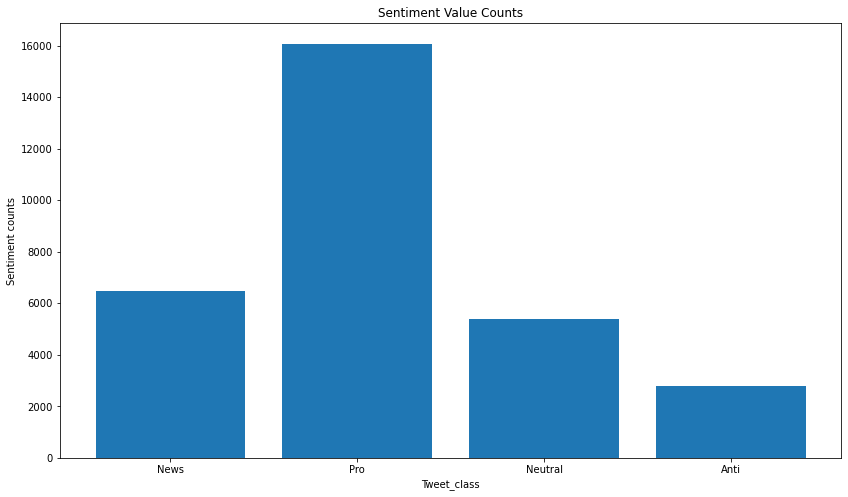

In [5]:
#A bar graph comparing the frequency of each class sentiment
news=dftrain[dftrain.sentiment == 2].shape[0]
pro =dftrain[dftrain.sentiment == 1].shape[0]
neutral=dftrain[dftrain.sentiment == 0].shape[0]
anti =dftrain[dftrain.sentiment == -1].shape[0]
#visualising
plt.figure(1,figsize=(14,8))
plt.bar(["News", "Pro", "Neutral" , "Anti"],[news, pro, neutral , anti])
plt.xlabel('Tweet_class')
plt.ylabel('Sentiment counts')
plt.title('Sentiment Value Counts')
plt.show()

From this graph we can see that the tweets with a higher word count frequency come from the PRO-class (Class1), that is the the tweets that supports the belief of man-made Climate-Change .We also notice that these four classes are imbalanced, which affects the accuracy score of the model negatively. This shows that resambling is necessary before training a model with this data.

We also learned that there is a good number of repeating tweets, retweets. Since resampling requires picking data randomly from a certain class to recreate it with a fixed number of entries, removing repeating retweets will allow fair random pick. Below we build a function that goes through the whole DataFrame removing all repeating tweets before resampling.

In [6]:
def remove_RT(df):
    """
        This function removes all the retweeted tweets before resampling so that we do not resample
        from already repeating tweets
    """
    df = df.copy()
    tweets = list(df['message'])
    New_tweets = []
    for tweet in tweets:
        if tweet not in New_tweets:
            New_tweets.append(tweet)
        else:
            New_tweets.append(None)
    df['message'] = New_tweets
    for twee in df['message']:
        if twee is None:
            ind = list(df['message']).index(twee)
            df.drop(df.index[ind], inplace = True)
    return df

In [7]:
def resambling(df):
    """
        The class size is a value between the size of the majority class and the size of the minority class.
        This function resamples by downsampling classes with observations greater than the class size and
        upsampling the classes with observations smaller than the class size.
    """
    df = df.copy()
    df = remove_RT(df)
    class_2 = df[df['sentiment'] == 2]  #upsampling
    class_1 = df[df['sentiment'] == 1]  #majority class
    class_0 = df[df['sentiment'] == 0]  #upsampling
    class_n1 = df[df['sentiment'] == -1]  #minority class
    class_size = int(((len(class_1)-len(class_n1))/2) + len(class_n1))
    #downsampling class 1
    rclass_1 = resample(class_1, replace=False, n_samples=class_size, random_state=27)
    #upsampling class 2
    rclass_2 = resample(class_2, replace=True, n_samples=class_size, random_state=27)
    #upsampling class 0
    rclass_0 = resample(class_0, replace=True, n_samples=class_size, random_state=27)
    #upsampling class -1
    rclass_n1 = resample(class_n1, replace=True, n_samples=class_size, random_state=27)
    dfsampled = pd.concat([rclass_2, rclass_1, rclass_0, rclass_n1])
    
    return dfsampled

This function resembles the data by making sure that each class has equal number of entries. This is done by recreating a class by picking at random from its entries until we have a desired class size. The class size is found by getting the midpoint from the lenth of a class with the least data and the lenth of a class with the most data. If a class has less data than the class size then random picking is done without replacement, if it is larger then random picking is done with replacement.

In [8]:
Resampled_Train_DF = resambling(dftrain)

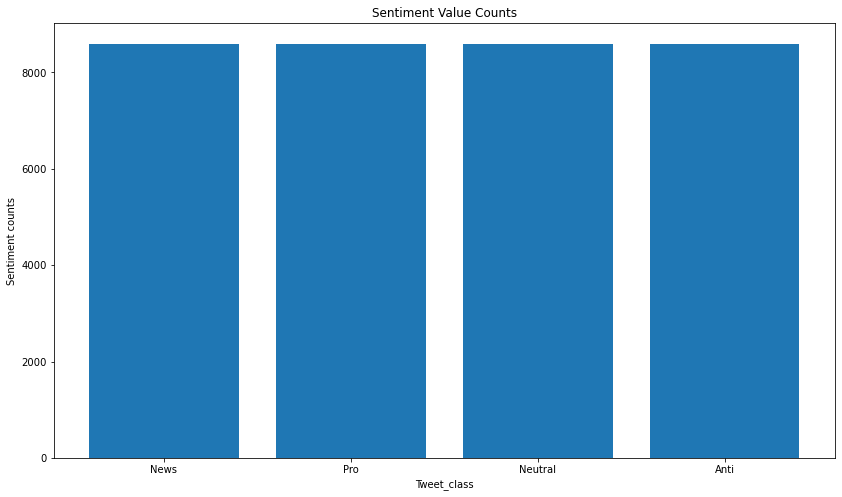

In [9]:
#A bar graph comparing the frequency of each class sentiment in resampled dataframe
news=Resampled_Train_DF[Resampled_Train_DF.sentiment == 2].shape[0]
pro =Resampled_Train_DF[Resampled_Train_DF.sentiment == 1].shape[0]
neutral=Resampled_Train_DF[Resampled_Train_DF.sentiment == 0].shape[0]
anti =Resampled_Train_DF[Resampled_Train_DF.sentiment == -1].shape[0]

#visualization
plt.figure(1,figsize=(14,8))
plt.bar(["News", "Pro", "Neutral" , "Anti"],[news, pro, neutral , anti])
plt.xlabel('Tweet_class')
plt.ylabel('Sentiment counts')
plt.title('Sentiment Value Counts')
plt.show()

# **Exploratory Data Analysis** <a name='Exploratory_data_analysis'>

- Word count analysis
- The number of punctuations 
- For Twitter Data: amount of retweets
- Word clouds for each class
- Sentiment analysis

In [10]:
# This line of code counts the number of words in each tweet and add a column of those counts into the existing dataframe 

word_count = dftrain['message'].apply(lambda x: len(x.split()))
dftrain['word_count'] = word_count


### **Word Count Boxplot**

<Figure size 1008x576 with 0 Axes>

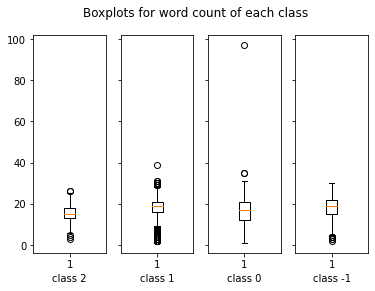

In [11]:
# create subplots
plt.figure(figsize=(14,8))
fig,axs = plt.subplots(1, 4, sharey = True)

# plot title
fig.suptitle('Boxplots for word count of each class')

# class 2 plot
y2 = dftrain[dftrain['sentiment'] == 2]['word_count']
axs[0].boxplot(y2)
axs[0].set_xlabel('class 2')

# class 1 plot
y1 = dftrain[dftrain['sentiment'] == 1]['word_count']
axs[1].boxplot(y1)
axs[1].set_xlabel('class 1')

# class 0 plot
y0 = dftrain[dftrain['sentiment'] == 0]['word_count']
axs[2].boxplot(y0)
axs[2].set_xlabel('class 0')

# class -1 plot
y_1 = dftrain[dftrain['sentiment'] == -1]['word_count']
axs[3].boxplot(y_1)
axs[3].set_xlabel('class -1')

plt.show()

The boxplots of word count show distinct properties for each class. The presence of outliers, varying medians and range sizes imply that the word count property will add substantial value to model training. neautral class have the highest range which implies that people with neautrl beliefs either write long tweets justyfying both sides or simply refuse to take a side as opose to anti and pro classes where people will write avarge words only justfying their beliefs.


### Word Count Distribution plot

C:\Users\KhosaZP\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\KhosaZP\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\KhosaZP\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an ax

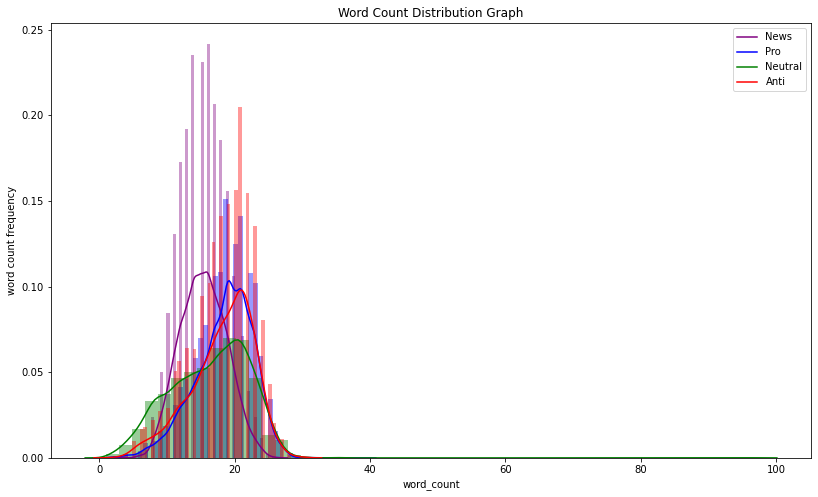

In [12]:
a1 =dftrain[dftrain.sentiment == 2]['word_count']
a2 =dftrain[dftrain.sentiment == 1]['word_count']
a3 =dftrain[dftrain.sentiment == 0]['word_count']
a4 =dftrain[dftrain.sentiment == -1]['word_count'] 
plt.figure(1,figsize=(30,8))
plt.subplot(1, 2, 1)
plt.ylabel('word count frequency')
sns.distplot(a1,color='purple',bins=50)
sns.distplot(a2,color='blue',bins=50)
sns.distplot(a3,color='green',bins=50)
sns.distplot(a4,color='red',bins=50)
plt.legend(['News','Pro', 'Neutral','Anti'])
plt.title('Word Count Distribution Graph')

plt.show()

This  graph shows the distribution of the word count frequency. It shows the relationship between the number of words in a tweet and it's class. From the graph we can see that the tweets from class News have a lenth from 5 to 25 and it's tweet lenth has normal distribution along mean 16. It also shows the same patten for the rest of the classes. With class Pro having work count lenths from 4 till 30, with more tweets around lenth 21. Class Neutral has lenths from 2 to 30, with most tweets around 20. And Class Anti has lenths from 4 to 30, with most tweets around 21. 

# Punctuation Count

In [13]:
# This line pf code counts the number of punctuation in each tweet then add the column of those counts into the existing dataframe

dftrain['punct_count']  = dftrain['message'].apply(lambda x: len([i for i in x if i in string.punctuation]))




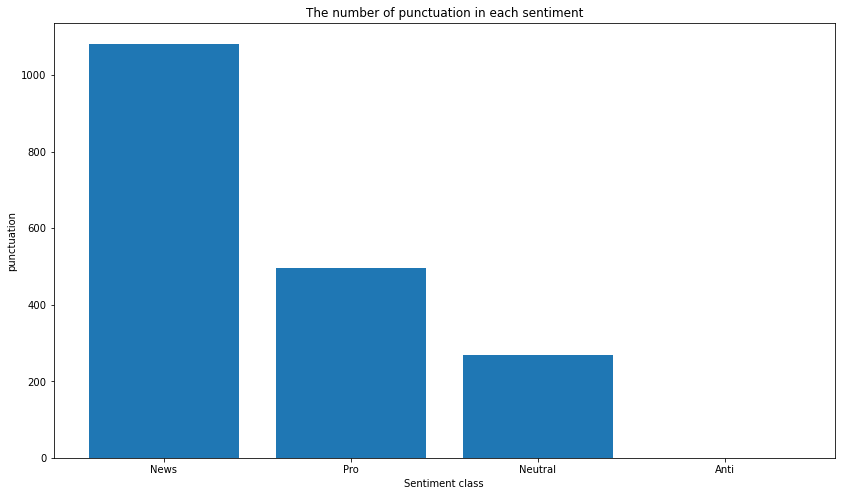

In [14]:
# A bar graph showing the number of punctuations as per class
# labling the classes
news=dftrain[dftrain.punct_count == 2].shape[0]
pro =dftrain[dftrain.punct_count == 1].shape[0]
neutral=dftrain[dftrain.punct_count == 0].shape[0]
anti =dftrain[dftrain.punct_count == -1].shape[0]

#plotting the graph and setting the axis labels
plt.figure(1,figsize=(14,8))
plt.bar(["News", "Pro", "Neutral" , "Anti"],[news, pro, neutral , anti])
plt.xlabel('Sentiment class')
plt.ylabel('punctuation')
plt.title('The number of punctuation in each sentiment')
plt.show() #visualizing the graph

This graph shows how punctuatiuation is used per class.The tweets from the News class (class 2) has the most punctuation use in the tweets, which shows how legitimate or factual take heed of puctuation the use of puntuation or grammar . We also notice how most tweets from the Anti class (class -1) make no use of punction. From this we can savely assume that most tweets that make less use of punctuation are mostly not factual.

### Analysing Stopwords


In [15]:
# A function that creates a corpus based on the target feature
def create_corpus(df,sentiment):
    """
    create corpus based on the target feature
    """
    list1 = []
    #appends each word from the messege to the list above and return the list
    for s in dftrain[dftrain["sentiment"]== sentiment].message.str.split():
        for i in s:
            list1.append(i)
    return list1    

In [16]:
#corpus created for each class
corpus2 = create_corpus(df=dftrain, sentiment=2)
corpus1 = create_corpus(df=dftrain, sentiment=1)
corpus0 = create_corpus(df=dftrain, sentiment=0)
corpus3 = create_corpus(df=dftrain, sentiment=-1)



d2= defaultdict(int)
for word in corpus2:
    if word in stop:
        d2[word]+=1
        
d1 =defaultdict(int)
for word in corpus1:
    if word in stop:
        d1[word]+=1
    
d0= defaultdict(int)
for word in corpus0:
    if word in stop:
        d0[word]+=1
        
d3= defaultdict(int)
for word in corpus3:
    if word in stop:
        d3[word]+=1
        
      
      

In [17]:
#sorting the results in descending order and get the firs 10 results
most2 = sorted(d2.items(), key=lambda x:x[1], reverse=True)[:10]
most1 = sorted(d1.items(), key=lambda x:x[1], reverse=True)[:10]
most0 = sorted(d0.items(), key=lambda x:x[1], reverse=True)[:10]
most3 = sorted(d3.items(), key=lambda x:x[1], reverse=True)[:10]
x2,y2 =zip(*most2)
x1 ,y1=zip(*most1)
x0 ,y0=zip(*most0)
x3 ,y3=zip(*most3)

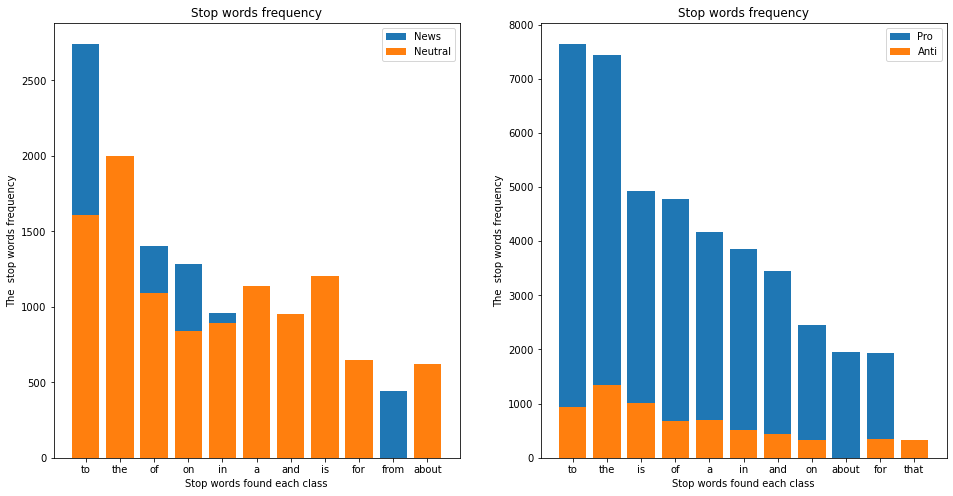

In [18]:
#ploting the graphs
plt.figure(1, figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.bar(x2,y2)
plt.title("Stop words frequency")
plt.ylabel('The  stop words frequency')
plt.xlabel('Stop words found each class')
plt.subplot(1, 2, 2)
plt.bar(x1, y1)
plt.title("Stop words frequency")
plt.ylabel('The  stop words frequency')
plt.xlabel('Stop words found each class')
plt.subplot(1, 2 , 1)
plt.bar(x0,y0)
plt.legend(['News','Neutral'])
plt.subplot(1 , 2, 2)
plt.bar(x3,y3)
plt.legend(['Pro','Anti'])



these are the stop words that were used in each class

# **Cleaning The Data** <a name='Cleaning_the_data'>

* Removing stopwords
* Removing punctuation
* Removing urls
* Removing characters
* Removing retweets


In [19]:
#making a copy of the dataframe which allows us to make some changes without changing the original dataframe
df_copy = dftrain.copy()
df_test = dftest.copy()

In [20]:
#using regular expressions to remove tagy symbols
def remove_pattern(input_txt, pattern):
    """
    this function checks for patterns in the input_txt and removes them
    """
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt

In [21]:
#applyng the funtion above to remove patterns on the message column
df_copy['message'] = np.vectorize(remove_pattern)(df_copy['message'], "@[\w]*") 
df_test['message'] = np.vectorize(remove_pattern)(df_test['message'], "@[\w]*") 



In [22]:

def  clean_text(df, text_field):
    """
    this function takes in a dataframe,text field and removes urls from the text field then return a dataframe with urls removed form the text field
    """
    df[text_field] = df[text_field].str.lower()
    df[text_field] = df[text_field].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))  
    return df
#test_clean = clean_text(clean_test_df, "message")
df_clean = clean_text(df_copy,"message")
df_test = clean_text(df_test,"message")

In [23]:
#A function that removes punctuations
def remove_punctuations(text):
    table = str.maketrans("","",string.punctuation)
    txt = text.translate(table)
    return txt
#removing punctuationd from the message column
df_clean["message"] = df_clean['message'].apply(remove_punctuations)
df_test["message"] = df_test['message'].apply(remove_punctuations)



In [24]:
#A function that removes stop words 
def remove_stopwords(text):
    text = [word.lower() for word in text.split() if word.lower() not in stop]
    r = " ".join(text)
    return r
#removing stop words from the message column
df_clean["message"]=df_clean["message"].apply(remove_stopwords)
#visualing the cleaned dataframe
df_clean.head()


,sentiment,message,tweetid,word_count,punct_count
0,-1,funny hell canada demands gender rights climat...,897853122080407553,21,7
1,-1,biggest lies climate change global warming deb...,925046776553529344,16,5
2,-1,coming revelation qglobal warmingq fraud resem...,696354236850786305,17,15
3,-1,lets see world ends climate change rollback go...,846806509732483072,21,13
4,-1,obama control climate worst snake oil salesman...,628085266293653504,19,9


### **Word Clouds from Cleaned Data**

A word cloud is a good representation to show the popular words one has in their data. Below we ploted a word cloud showing the most popular words in our data.

In [25]:
df_clean['message'] = df_clean['message'].apply(lambda x: x.replace('climate change',''))
df_clean['message'] = df_clean['message'].apply(lambda x: x.replace('global warming',''))
df_test['message'] = df_clean['message'].apply(lambda x: x.replace('climate change',''))
df_test['message'] = df_clean['message'].apply(lambda x: x.replace('global warming',''))


we firstly did word cloud visualisation with stopwords,puctuations,urls and patterns removed. We noticed how words like Climate-Change , Global warming etc takes up a huge font meaning they were mostly mentioned in the tweet messages. We decided to remove those words using the function above to get a more distinct words within our tweet messages

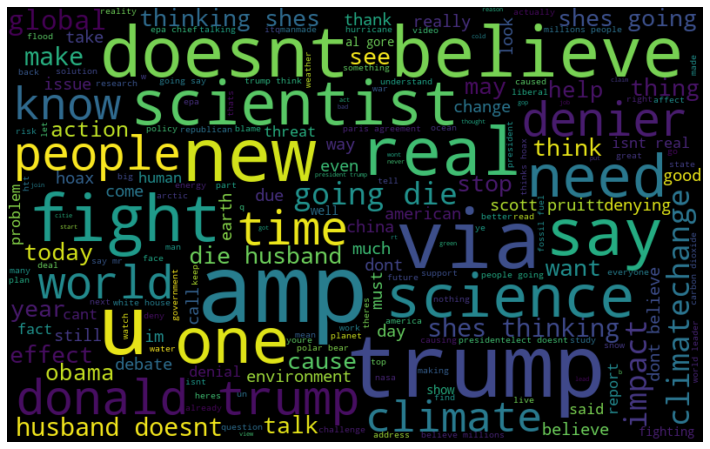

In [26]:
# Word cloud for the overall data checking out which words do people use more often
all_words = ' '.join([text for text in df_clean['message']])

# Word cloud for the overall data checking out which words do people use more often
wordcloud = WordCloud(width=800, height=500,random_state=21,max_font_size=110).generate(all_words)

#ploting the word cloud
plt.figure(figsize=(16,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show() #visualizing the word cloud 

Word clouds for each class Indeed we expected words like climate change and global warming to appear more often as these are the topics of the subjects, this gives an assurance that we obtained relevant tweets/data to our topic

### **Word Cloud Per Class**

In [27]:
class2_words = ' '.join([text for text in df_clean[dftrain['sentiment']==2]['message']])
class1_words = ' '.join([text for text in df_clean[dftrain['sentiment']==1]['message']])
class0_words = ' '.join([text for text in df_clean[dftrain['sentiment']==0]['message']])
class_neg1_words = ' '.join([text for text in df_clean[dftrain['sentiment']==-1]['message']])

#visualizing the classes
wordcloud2 = WordCloud(width=800, height=500,random_state=21,max_font_size=110).generate(class2_words)
wordcloud1 = WordCloud(width=800, height=500,random_state=21,max_font_size=110).generate(class1_words)
wordcloud0 = WordCloud(width=800, height=500,random_state=21,max_font_size=110).generate(class0_words)
wordcloudneg1 = WordCloud(width=800, height=500,random_state=21,max_font_size=110).generate(class_neg1_words)

<Figure size 72000x36000 with 0 Axes>

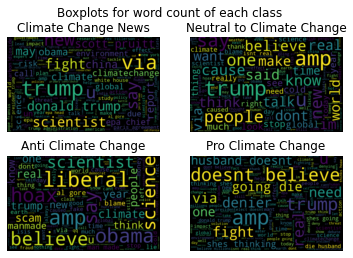

In [28]:
fig = plt.figure(figsize=(1000,500))
fig,axs = plt.subplots(2, 2)
fig.suptitle('Boxplots for word count of each class')

# word cloud plots
axs[0,0].imshow(wordcloud2, interpolation="bilinear")
axs[1,1].imshow(wordcloud1, interpolation="bilinear")
axs[0,1].imshow(wordcloud0, interpolation="bilinear")
axs[1,0].imshow(wordcloudneg1, interpolation="bilinear")

# removing axes
axs[0,0].axis('off')
axs[1,1].axis('off')
axs[0,1].axis('off')
axs[1,0].axis('off')

# word cloud titles
axs[0,0].set_title('Climate Change News')
axs[1,1].set_title('Pro Climate Change')
axs[0,1].set_title('Neutral to Climate Change')
axs[1,0].set_title('Anti Climate Change')

plt.show() 

The key take away from these word clouds is that each class has its own distinct predominant words(or phrases), broken down as follows:

* News: "Donald Trump" 
* Neutral: "People" 
* Anti: "Climate"
* Pro: "Believe" 

# **Feature Engeneering** <a name='Feature_engeneering'>

### Extracting websites from tweets <a name='Extracting_websites_from_tweets'>

In [29]:
df_clean['sites'] = dftrain['message'].apply(lambda x: re.search("(?P<url>https?://[^\s]+)", x).group("url") if 'https' in x and re.search("(?P<url>https?://[^\s]+)", x) != None else None)


### polarity and subjectivity

In [30]:
def get_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def get_polarity(text):
    return TextBlob(text).sentiment.polarity

df_clean['subjectivity'] = df_clean["message"].apply(get_subjectivity)

df_clean['polarity'] = df_clean['message'].apply(get_polarity)
df_clean.head()


,sentiment,message,tweetid,word_count,punct_count,sites,subjectivity,polarity
0,-1,funny hell canada demands gender rights trade...,897853122080407553,21,7,None,1.0,0.25
1,-1,biggest lies debunked one astonishing interview,925046776553529344,16,5,https://t.co/NgvIPO4wYA,1.0,0.50
2,-1,coming revelation qq fraud resembles obamacare...,696354236850786305,17,15,https://t.co/1dIOrfkslx,0.0,0.00
3,-1,lets see world ends rollback goes effect hint...,846806509732483072,21,13,https://t.…,0.0,0.00
4,-1,obama control climate worst snake oil salesman...,628085266293653504,19,9,https://t.co/YTQfO5FzbW,1.0,-1.00


## Sentiment Analysis

In [31]:
 #polarity and subjectivity plot
# plt.figure(figsize=(16,8))
# for i in range(0, df_clean.shape[0]):
#     plt.scatter(df_clean['polarity'][i],df_clean['subjectivity'][i], color = 'Blue')
    
# plt.title('Sentiment analysis')
# plt.xlabel('Polarity')
# plt.ylabel('Subjectivity')
# plt.show()


Acording to the sentiment analysis This tells we have majority of the tweets a clastured at the center. Which tells us that based onn the polarity a lot opf tweets are recognised as neutral tweets

# Model building and Selection

We buld three different models
* SKlearn Pipeline Model
* Logistic Regression Model
* Support Vector Marchine (SVM) Model

# **Building our SKlearn Pipeline Model**

The pipeline class is one of sklearn classification estimators, it enables usage of various vectorizers such as tfidfvectorizer. This goes in combination with a fitting algorithm like support vector machine. The advantage of a pipeline estimator is that it automatically encoporates the preprocessing (vectorizing), fitting and transformation of the data in minimal lines of code.

### A flow diagram of the tfidvectorizer

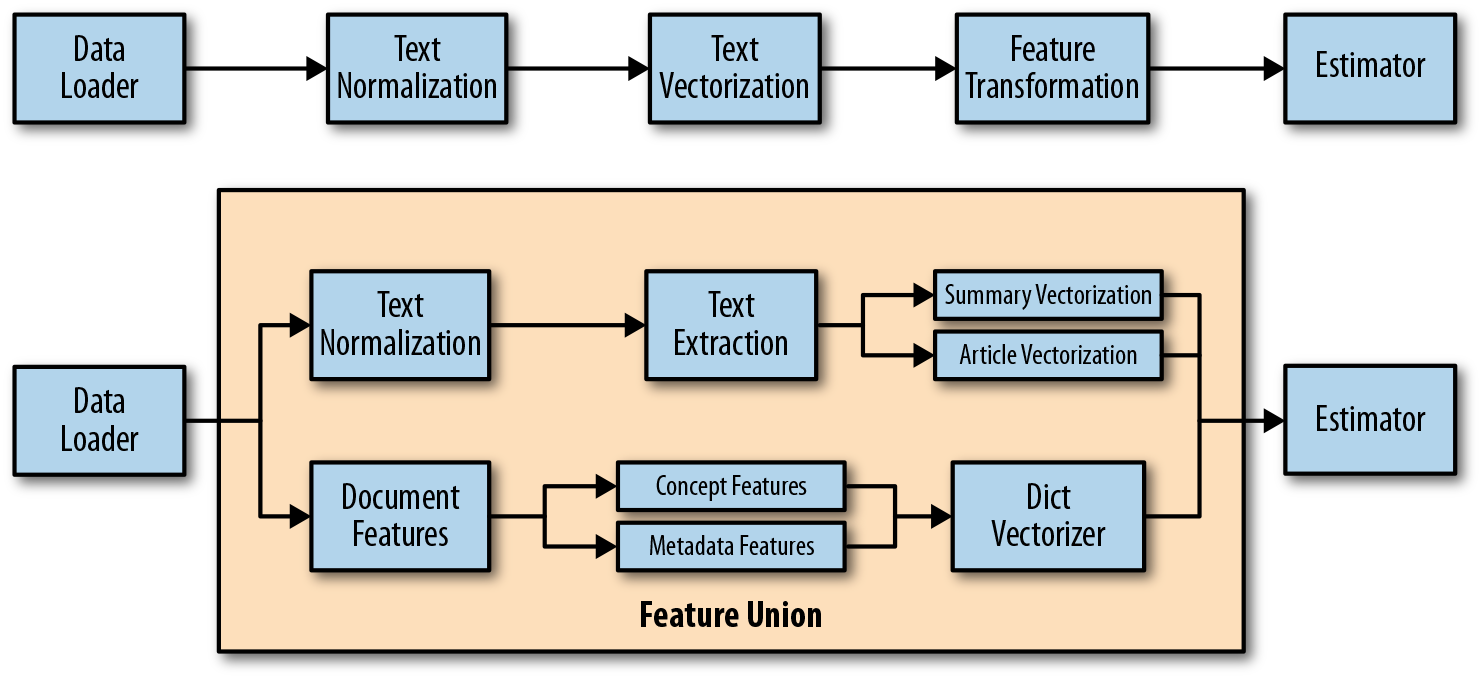

## Splitting Train data and Assigning Test data

In [32]:
# splitting the training data
X = dftrain['message']  
y = dftrain['sentiment']
Xt = dftest['message']



In [34]:
# Checking the shape of the test data
Xt.shape

(10546,)

#### Vectorize and scale the test and train data

In [35]:
# to vectorise the data
vect= CountVectorizer(ngram_range=(1, 7), stop_words='english').fit(X)

X= vect.transform(X)
T= vect.transform(Xt)

In [36]:
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler

In [37]:
# Normalizing the X_train
norm= MaxAbsScaler().fit(X)
X= norm.transform(X)
T= norm.transform(T)

# **Building Our Logistic Regression Model** <a name='Building_our_logistic_regression_model'>

In [38]:
logreg_1= LogisticRegression()

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
logreg_1.fit(X, y)

In [ ]:
y_pred= logreg_1.predict(X_test)

In [ ]:
T.shape[0]+1

In [ ]:
YY= logreg_1.predict(T)

In [ ]:
b= dftest['tweetid']

In [ ]:
sub_df= pd.DataFrame({'tweetid': b, 'sentiment': YY})

In [ ]:
sub_df

In [84]:
sub_df.to_csv('Classification_tweets_predict.csv', index=False)

# **Model Matrices** <a name='Model_matrices'>

we will firstly look at the Definations of :
*     accuracy_score
*     precission_score
*     recall_score
*     f1_score.
*     Confution matrix
     

 ### Accuracy -
Accuracy is the most intuitive performance measure and it is simply a ratio of correctly predicted observation to the total observations [[4](https://blog.exsilio.com/all/accuracy-precision-recall-f1-score-interpretation-of-performance-measures/)]. 

Using the formula:  $$ Accuracy = \frac{Correct \space predictions}{Total \space predictions} = \frac{TP \space + TN}{TP \space + TN \space + FP \space + FP} $$


### Precision -
Precision is the ratio of correctly predicted positive observations to the total predicted positive observations [[4](https://blog.exsilio.com/all/accuracy-precision-recall-f1-score-interpretation-of-performance-measures/)]. 

Using the formula: $$ Precision = \frac{TP}{TP \space + FP} = \frac{TP}{Total \space Predicted \space Positive} $$


### Recall (Sensitivity) - 
Recall is the ratio of correctly predicted positive observations to the all observations in actual class [[4](https://blog.exsilio.com/all/accuracy-precision-recall-f1-score-interpretation-of-performance-measures/)]. 

Using the formula: $$ Recall = \frac{TP}{TP \space + FN} = \frac{TP}{Total \space Actual \space Positive}$$

### F1 score - 
F1 Score is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account. Intuitively it is not as easy to understand as accuracy, but F1 is usually more useful than accuracy, especially if you have an uneven class distribution [[4](https://blog.exsilio.com/all/accuracy-precision-recall-f1-score-interpretation-of-performance-measures/)].

Using the formula: $$F_1 = 2 \times \frac {Precision \space \times \space Recall }{Precision \space + \space Recall }$$





In [85]:
conf_matrix = metrics.confusion_matrix(y_test,y_pred)
print("Confusion matrix \n\n {}".format(conf_matrix))

Confusion matrix 

 [[ 834    1    0    0]
 [   1 1622    0    0]
 [   0    1 4858    2]
 [   0    0    0 1909]]


In [86]:
accu_score = metrics.accuracy_score(y_test,y_pred) 
print('Accuracy Score = {}'.format(accu_score))

Accuracy Score = 0.9994581707845687


In [87]:
precision = precision_score(np.array(y_test), y_pred, average = 'weighted')
print('Precision Score = {}'.format(precision))

Precision Score = 0.9994585310654577


In [88]:
recall = recall_score(y_test, y_pred, average = 'weighted')
print('Recall Score = {}'.format(recall))

Recall Score = 0.9994581707845687


In [89]:
f1 = f1_score(y_test, y_pred, average = 'weighted')
print("F1_Score = {}".format(f1))

F1_Score = 0.9994582274072934


In [90]:
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       835
           0       1.00      1.00      1.00      1623
           1       1.00      1.00      1.00      4861
           2       1.00      1.00      1.00      1909

    accuracy                           1.00      9228
   macro avg       1.00      1.00      1.00      9228
weighted avg       1.00      1.00      1.00      9228



In [91]:
#creating a copy of our dataframe
df_copy = dftrain.copy()

In [92]:
#visualising the copy of the dataframe
df_copy.head()

,sentiment,message,tweetid
0,-1,RT @darreljorstad: Funny as hell! Canada deman...,897853122080407553
1,-1,All the biggest lies about climate change and ...,925046776553529344
2,-1,The Coming Revelation Of The $q$Global Warming...,696354236850786305
3,-1,RT @DineshDSouza: Let's see if the world ends ...,846806509732483072
4,-1,RT @SteveSGoddard: Obama has no control over t...,628085266293653504


In [93]:
#variable assignment
X= np.array(dftrain['message'])
y= np.array(dftrain['sentiment'])

#splitting the dataset into training and validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#standardizing the data set
#from sklearn.preprocessing import Normalizer
#normalise = Normalizer()
#X_train = normalise.fit_transform(X_train)
#X_test = normalise.fit_transform(X_test)


#transforming the sentiments
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

#selecting the logistic regression model from sklearn and selecting lbfgs as our solver
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression(solver='lbfgs')

lr_model.fit(X_train, y_train)
predictions = lr_model.predict(X_test)
#predictions[0]

# pickle
#model_save_path = "lr_model.pkl"
#with open(model_save_path,'wb') as file:
   # pickle.dump(lr_model, file)

C:\Users\KhosaZP\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


###  Testing the Accuracy of the Model

In [94]:
#importing the metrics library
from sklearn import metrics

# Printing a confusion matrix
print(metrics.confusion_matrix(y_test,predictions))

[[ 197   78  204   37]
 [  42  387  544  122]
 [  30   96 2865  263]
 [   7   23  280  977]]


In [95]:
# creating a dataframe of the confusion matrix 
df_confusion = pd.DataFrame(metrics.confusion_matrix(y_test,predictions))
#visualing the confusion dataframe
df_confusion

,0,1,2,3
0,197,78,204,37
1,42,387,544,122
2,30,96,2865,263
3,7,23,280,977


In [96]:
# Print a classification report
print(metrics.classification_report(y_test,predictions))

              precision    recall  f1-score   support

          -1       0.71      0.38      0.50       516
           0       0.66      0.35      0.46      1095
           1       0.74      0.88      0.80      3254
           2       0.70      0.76      0.73      1287

    accuracy                           0.72      6152
   macro avg       0.70      0.59      0.62      6152
weighted avg       0.71      0.72      0.70      6152



the model seems to be perfoming better for the classes that has more messages

In [97]:
# Print the overall accuracy
print(metrics.accuracy_score(y_test,predictions))

0.7194408322496749


 # **Building the SVM Model** <a name='Building_the_SVM_model'>

SVM (Support Vector Machines) uses the training data and plots the data as points in space, it will then find a separating gap between two clases and use this gap as a dividing line(hyperplane), the new data will be classified acording to this deviding line. we will first copy the data to use in our SVM model

In [98]:
df_SVM_train = dftrain.copy()
df_SVM_test=dftest.copy()

In [99]:
#Removing puncuations from the messege column so that we can use the text only for the model
def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text

In [100]:
df_SVM_test["message"] = df_SVM_test['message'].apply(remove_punctuations)
df_SVM_test["message"] = df_SVM_test['message'].apply(remove_punctuations)

In [101]:
#Defining training and testing data
#Defining training and testing data
X_SVM = df_SVM_train['message']

y_SVM = df_SVM_train['sentiment']


x_test = df_SVM_test['message']

SVM uses numerical data so the data will be converted to numerical data using CountVectorizer

In [102]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()

X_train_counts = count_vect.fit_transform(X_SVM)
X_train_counts.shape

(30759, 57242)

In [103]:
#Transforming also the x_test data to numerical data
X_test_counts = count_vect.transform(x_test)
X_test_counts.shape

(10546, 57242)

splitting the dataset into training and validation set

In [104]:
from sklearn.model_selection import train_test_split

x_train, x_test, Ytrain, Ytest = train_test_split(X_train_counts, y_SVM, test_size=0.2, random_state=42)

from above we saw that our data have the matching shape so we will proceed to fitting the data using svm model


## **Fitting our data using SVM model**

In [ ]:
from sklearn.svm import SVC  # to be added on the import cell
svm = SVC()
svc = SVC(kernel='linear')
svc.fit(x_train, Ytrain)

In [98]:
ypred = svc.predict(x_test)

# **Testing the Accuracy of the Model, by compering the predicted values vs tesing values**

In [ ]:
#importing the metrics library
from sklearn import metrics

# Printing a confusion matrix
print(metrics.confusion_matrix(Ytest,ypred))

In [100]:
# Print the overall accuracy
print(metrics.accuracy_score(Ytest,ypred))

0.7082249674902471


In [101]:
# creating a dataframe of the confusion matrix 
df_confusion = pd.DataFrame(metrics.confusion_matrix(Ytest,ypred))
#visualing the confusion dataframe
df_confusion

,0,1,2,3
0,269,107,110,30
1,87,560,373,75
2,112,332,2562,248
3,13,70,238,966


## **Predicting the results of the provided testing set from our fitted SVM model**

In [102]:
y_pred = svc.predict(X_test_counts)


Saving the results to a csv file named SVM_Predictions

In [101]:
s=pd.DataFrame(y_pred)
f_new = s.rename(columns={0: 'sentiment'})
tweedid=df_SVM_test['tweetid']
df_merge_col = pd.merge(tweedid, f_new, left_index=True, right_index=True)
df_merge_col.to_csv('SVM_Tweets_prediction_Model.csv',index=False)

# **Log Model Features To Comet_ml** <a name='Log_model_features_to_Comet_ml'>

In [65]:
#Create a dictionary of model parameters
params = {"random_state": 42,
          "model_type": "Pineline",
          "feature_extraction": "TfidfVectorizer"
          }

In [66]:
#Create dictionary of important metrics
metrics = {"f1": f1,
           "Accuracy_Score": accu_score,
           "recall": recall,
           "precision": precision
           }

In [67]:
# Log our parameters and results
experiment.log_parameters(params)
experiment.log_metrics(metrics)

# Conclusion <a name='Conclusion'>

In this Notebook, we conducted a whirlwind overview of vectorization techniques and began to consider their use cases for different kinds of data and different machine learning algorithms. we noticed some imbalance in the classes and decided to upscale the classes .

We have trained a couple of models and in conclusion we chose the tfidfvectorizer Pipeline Model because it substaintially outperformed other models for certain tasks. It also gave an accuracy score that is higher than that of theother models. This model will be able to classify whether or not a person believes in climate change, based on their novel tweet data.

In [68]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/percymokone/classification-team-ts3/4d94d247254d493cab6632c05576fc49
COMET INFO:   Metrics:
COMET INFO:     Accuracy_Score : 0.7496839443742098
COMET INFO:     f1             : 0.7398920960204146
COMET INFO:     precision      : 0.7424919180281266
COMET INFO:     recall         : 0.7496839443742098
COMET INFO:   Parameters [count]:
COMET INFO:     C                     : 1.0
COMET INFO:     class_weight          : 1
COMET INFO:     clf_C                 : 1.0
COMET INFO:     clf_class_weight      : 1
COMET INFO:     clf_dual              : True
COMET INFO:     clf_fit_intercept     : True
COMET INFO:     clf_intercept_scaling : 1
COMET INFO:     clf_loss              : squared_hinge
COMET INFO:     clf_max_iter          : 1000
COMET INFO:     clf_

# References <a name='References'>

[1] Lim, L.-A., 2019. Unsplash. [Online] 
Available at: https://unsplash.com/photos/ycW4YxhrWHM
[Accessed 28 June 2020].

[2] Revkin, A., 2018. Climate Change First Became News 30 Years Ago. Why Haven’t We Fixed It?. [Online] 
Available at: https://www.nationalgeographic.com/magazine/2018/07/embark-essay-climate-change-pollution-revkin/
[Accessed 27 June 2020].

[3] Hub, I., 2018. 5 Big Companies Reducing Their Carbon Footprints. [Online] 
Available at: https://impacthub.net/5-big-companies-reducing-their-carbon-footprints/
[Accessed 27 June 2020].

[4] Renuka, J 2016, Accuracy, Precision, Recall & F1 Score: Interpretation of Performance Measures ,  Exsilio Solutions, viewed 23 June 2020, https://blog.exsilio.com/all/accuracy-precision-recall-f1-score-interpretation-of-performance-measures/
